### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

## Transfer Learning
    ### Feature Extractor:
        - freeze first layers and train on last 2 layers + softmax
        - good for small dataset

    ### Finetuning:
        - train on last layers on archetcture
        - medium dataset

In [1]:
import torch
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline
import os
import random
import shutil
import numpy as np

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn

from itertools import islice

from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from ResNet18 import ResNet18
from ResNet18 import IdentityBlock
from ResNet18 import ConvBlock

import albumentations as A
from copy import deepcopy  # in case you still need original model
#import cv2
#from albumentations.pytorch import ToTensor

import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

### Get Labels

In [3]:
s = open('imagenet.txt', 'r').read()
labels = eval(s)

print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [4]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/iris/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


tensor([[-1.2296,  0.9183,  1.7149,  ..., -1.9617, -0.4233,  1.7333],
        [-1.0729,  1.1140,  1.8522,  ..., -2.1540, -0.5075,  1.7838],
        [-0.9518,  1.0651,  1.8698,  ..., -2.1580, -0.5218,  1.5306],
        [-1.1516,  0.7177,  1.3770,  ..., -2.2047, -0.6353,  1.6362],
        [-1.1897,  0.6498,  1.6672,  ..., -2.2979, -0.5394,  1.7144]],
       grad_fn=<AddmmBackward>)

In [6]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

### Predict class probabilities

In [ ]:
# If using Colab
#!mkdir sample_images
#!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

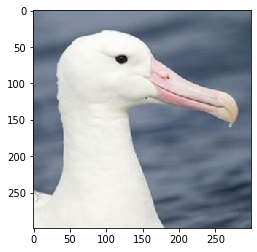

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [7]:
img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [ ]:
#!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

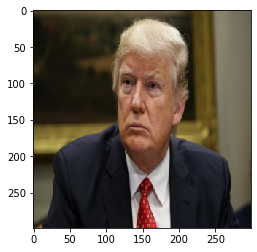

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	groom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	Loafer
0.0032 :	wig
0.0028 :	Afghan hound
0.0027 :	bow tie


In [8]:
img = resize(plt.imread('sample_images/img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
#!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
#!unzip -n data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [16]:
embedding.Mixed_7b.branch1x1

BasicConv2d(
  (conv): Conv2d(1280, 320, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(320, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [10]:
#extract features from images
from tqdm import tqdm
from imageio import imread
#import imageio
import PIL.Image as Image
import os
import numpy as np

device = torch.device(("cuda:1") if torch.cuda.is_available() else "cpu")
embedding.to(device)

X = []
Y = []

batch_size = 250
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0
embedding.eval()

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img    
    
    with torch.no_grad():
        if batch_index == batch_size - 1:
            input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
            input_tensor = input_tensor.to(device)

            # use your embedding model to produce feature vector
            features = embedding(input_tensor)

            X.append(features.cpu())

            batch_index = 0
            continue

        batch_index += 1

100%|██████████| 25000/25000 [02:28<00:00, 168.74it/s]


In [11]:
X = np.concatenate(X)
X.shape

# Y = np.array(Y[:len(X)])

#print(X.shape, Y.shape) 

(25000, 2048)

In [12]:
len(Y)
X.shape

(25000, 2048)

## Split data here or use cross-validation

In [13]:
from sklearn.model_selection import train_test_split

Y = np.asarray(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)

print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (16750, 2048)
X_test (8250, 2048)
y_train (16750,)
y_test (8250,)


### RandomForestClassifier

In [47]:
clf=RandomForestClassifier(n_estimators=100)

clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.9831515151515151


### ExtraTreesClassifier

In [48]:
extra_tree_classifier=ExtraTreesClassifier(n_estimators=100)

extra_tree_classifier.fit(X_train, y_train)

y_pred=extra_tree_classifier.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.9826666666666667


### GradientBoostingClassifier

In [49]:
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                                   max_depth=3)

gradient_boosting_clf.fit(X_train, y_train)

y_pred=gradient_boosting_clf.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.984


### AdaBoostClassifier

In [50]:
ada_boost_clf = AdaBoostClassifier(n_estimators=100, random_state=0)

ada_boost_clf.fit(X_train, y_train)

y_pred=ada_boost_clf.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.9826666666666667


### Logistic Regression

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred>0.5))

NameError: name 'LinearRegression' is not defined

### RidgeClassifier

In [52]:
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred_ridge>0.5))

accuracy 0.9872727272727273


# Main Quest Helper Functions

### Dataset

In [4]:
os.chdir('/home/iris/paulshab/ShadLab5/')

resnet_train_transform = A.Compose([
    A.Rotate(limit=[-30, 30], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CenterCrop(width=25, height=25, p=0.3),
    A.Resize(height=32, width=32),
    A.Resize(height=224, width=224),
    ToTensor(),
])

resnet_test_transform = A.Compose([
    A.Resize(height=224, width=224),
    ToTensor(),
])


# Make Datatset
t = Compose([
    Resize((224, 224)),
    ToTensor(),
])

train_dataset = ImageFolder("sample_data/train/", transform=t)
test_dataset = ImageFolder("sample_data/test/", transform=t)


print(len(train_dataset))
print(len(test_dataset))

15983
4517


In [5]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

### Dataloader

In [6]:
def get_loaders(training_set, testing_set, batch_size=16):
    trainloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )

    testloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        drop_last=True
    )
    return trainloader, testloader

trainloader, testloader = get_loaders(train_dataset, test_dataset)

### Check Dataloader

In [7]:
batch = next(iter(trainloader))
images, labels = batch

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


### Check Forward Pass

In [8]:
def check_forward_pass(net, trainloader):  
    for batch in islice(trainloader, 0, 1):
        images, labels = batch
        y_pred = net(images)
        print(y_pred.shape)

### Check Forward Pass Cuda

In [9]:
def check_forward_pass_cuda(net, trainloader):
    net.to(device)
    for batch in islice(trainloader, 0, 1):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        y_pred = net(images)
        print(y_pred.shape)

### Display Images

cat
AxesImage(54,36;334.8x217.44)


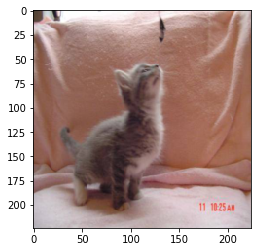

In [10]:
class_names = ['cat','dogs']

def display_images():
    k = random.randint(0, 15000)
    img = np.array(train_dataset[k][0])
    img = np.transpose(img, (1, 2, 0))
    
    print(class_names[train_dataset[k][1]])
    print(plt.imshow(img))


display_images()

### Load Pretrained Model

In [11]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
#     for parameter in model.parameters():
#         parameter.requires_grad = False

#     model.eval()
    return model

### Get Convergence Graph:

In [12]:
def convergence_graph(loss_vals):
    print("min loss value", loss_vals[-1])

    plt.plot(range(1, len(loss_vals) +1), loss_vals, color ='blue')
    plt.rcParams["figure.figsize"] = (10,6)
    plt.grid()
    plt.xlabel("Number of iterations")
    plt.ylabel("cost (J)")
    plt.title("Convergence of gradient descent")

### Train Model

In [13]:
device = torch.device(("cuda:0") if torch.cuda.is_available() else "cpu")
num_epochs = 10

def train_model(model, trainloader):
    model.to(device)
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss = []

    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in trainloader: 
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images)
            loss = criterion(logits, labels.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_batch_loss.append(loss.item())
            
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        train_loss.append(avg)
    return train_loss

### Eval Model

In [14]:
device = torch.device(("cuda:1") if torch.cuda.is_available() else "cpu")
class_names = np.array([3, 5])

def eval_model(model, loader, change_labels=False):
    model.to(device)
    model.train(False)
    test_batch_acc = []
    for batch in testloader:
        images, labels = batch
        if change_labels:
            labels=torch.from_numpy(class_names[labels])
        images, labels = images.to(device), labels.to(device)
        #print(labels)
        y_pred = model(images)
        y_pred = y_pred.max(1)[1].data.cpu().numpy()
        #print(y_pred)
        
        #print(y_pred)
        test_batch_acc.append(np.mean(labels.cpu().numpy() == y_pred))
    test_accuracy = np.mean(test_batch_acc) * 100
    return test_accuracy

### Feature Extractor

In [15]:
def get_features(model, loader):
    X = []
    Y = []
    model.train(False)
    for batch in loader:
        images, labels = batch
        Y.append(labels)
        images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        with torch.no_grad():
            features = model(images)
            #print(features.shape)
            X.append(features.cpu())
    
    X = np.concatenate(X)
    Y = np.concatenate(Y)

    return X, Y

### FineTuned Helper

In [16]:
class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        #print("shape", x.shape)
        return x
           

# Models
    -  can i define model and weights from one file?
    -  res_net.fc.state_dict() --> modified res_net.fc.state_dict()
    -  how to delete flattened layer
    

### Pretrained Model 10 Classes

In [17]:
# load model
res_net = load_checkpoint('/home/iris/paulshab/ShadLab4/checkpoint2.pth')

# check forward pass
check_forward_pass_cuda(res_net , testloader)

# eval model
print("accuracy", eval_model(res_net, testloader, change_labels=True))

# print fc layer
res_net.fc.state_dict()

torch.Size([16, 10])
accuracy 65.49202127659575


OrderedDict([('weight',
              tensor([[-0.3940, -0.3647, -0.2019,  ..., -0.0084, -0.1540,  0.3579],
                      [ 0.4035, -0.8657,  0.3432,  ...,  0.0253,  0.2301, -0.2961],
                      [ 0.0721, -0.2215, -1.0862,  ..., -0.7245, -0.0658,  0.2450],
                      ...,
                      [-0.1169, -0.1775,  0.1429,  ...,  0.2120,  0.7891, -0.9474],
                      [-0.4718,  0.5392,  0.5222,  ...,  0.1365, -0.5229, -0.5170],
                      [ 0.3197, -0.0159, -0.1260,  ...,  0.3621,  0.2395, -0.1066]],
                     device='cuda:1')),
             ('bias',
              tensor([-0.0684, -0.1025,  0.0329, -0.0130,  0.1410, -0.0826,  0.0435, -0.0145,
                      -0.0320,  0.0168], device='cuda:1'))])

### Edited Pretrained Model 2 Classes

In [18]:
res_net_edit = deepcopy(res_net)

res_net_edit.fc = nn.Linear(in_features=512, out_features=2, bias=True)

# check forward pass
check_forward_pass_cuda(res_net_edit, testloader)

# eval model
print("accuracy", eval_model(res_net_edit, testloader))

# print fc layer
res_net_edit.fc.state_dict()

torch.Size([16, 2])
accuracy 50.19946808510638


OrderedDict([('weight',
              tensor([[ 0.0165, -0.0308,  0.0416,  ..., -0.0403,  0.0210, -0.0430],
                      [ 0.0414, -0.0018,  0.0392,  ...,  0.0265,  0.0384,  0.0286]],
                     device='cuda:1')),
             ('bias', tensor([-0.0212,  0.0227], device='cuda:1'))])

### Feature Extractor Model

In [19]:
from sklearn.linear_model import LogisticRegression

feature_ex = deepcopy(res_net)

feature_ex.fc = Identity()

X_train, y_train = get_features(feature_ex, trainloader)
X_test, y_test = get_features(feature_ex, testloader)

print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape) 

(15968, 512) (15968,)
(4512, 512) (4512,)


In [20]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred))

accuracy 0.8945035460992907


/home/iris/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

print("accuracy", accuracy_score(y_test, y_pred_ridge))

accuracy 0.8858599290780141


In [22]:
res_net

ResNet18(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): IdentityBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): IdentityBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=

### Fine Tuned Model

  0%|          | 0/30 [00:00<?, ?it/s]

torch.Size([16, 2])


100%|██████████| 30/30 [19:41<00:00, 39.39s/it]

min loss value 0.008616422903222084


91.77748226950354

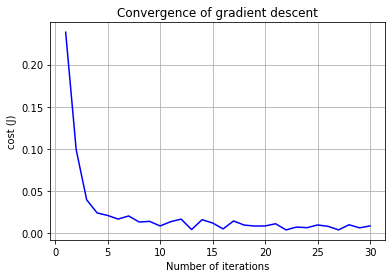

In [26]:
fine_tuned = deepcopy(res_net)  # basic finetuning

fine_tuned.fc = nn.Linear(in_features=512, out_features=2, bias=True)

#check_forward_pass(fine_tuned, trainloader)

# check forward pass
check_forward_pass_cuda(fine_tuned, trainloader)

# train model
loss_vals = train_model(fine_tuned, trainloader)

# get convergence graph
convergence_graph(loss_vals)

# eval model
eval_model(fine_tuned, testloader)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())

In [ ]:
preprocess = transforms.Compose([
#    transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))